# MUTI CLASIFICATION LUNG

In [47]:
import pandas as pd
import random
import numpy as np
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig, AutoModelForImageClassification
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import os
import shutil
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch import device
from torchvision import transforms

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoImageProcessor, ViTForImageClassification

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

## LOAD DATASET

In [48]:
# Load train and validation data
df_train = pd.read_csv('./CheXpert-v1.0-small/train.csv')
df_val = pd.read_csv('./CheXpert-v1.0-small/valid.csv')

if not df_train.empty and not df_val.empty:
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


In [49]:
# Display first 5 rows of validation data
df_train.tail(1)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223413,CheXpert-v1.0-small/train/patient64540/study1/...,Female,0,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [50]:
df_val.tail(1)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
233,CheXpert-v1.0-small/valid/patient64740/study1/...,Male,90,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [51]:
df_train.describe()

,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,223414.000000,22381.0,44839.000000,46203.000000,117778.000000,11944.000000,85956.000000,70622.000000,27608.000000,68443.000000,78934.000000,133211.000000,6492.000000,12194.000000,123217.000000
mean,60.430653,1.0,-0.035795,0.409346,0.848911,0.644508,0.456769,-0.183498,-0.461134,-0.005304,0.206540,0.559706,0.134011,0.688699,0.932680
std,17.820925,0.0,0.718442,0.769323,0.472571,0.691607,0.741785,0.753980,0.828249,0.990244,0.493529,0.648859,0.966183,0.565435,0.283377
min,0.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,49.000000,1.0,-1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
50%,62.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,74.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Unik

In [52]:
# Cetak jumlah data unik pada setiap kolom di train_df (kecuali 'Path')
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):")
unique_counts = df_train.loc[:, ~df_train.columns.isin(['Path'])].nunique()
unique_values = df_train.loc[:, ~df_train.columns.isin(['Path'])].apply(lambda x: [str(val) for val in x.unique()])
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values.apply(lambda x: ', '.join(x))})
print(result)


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):
                            Unique Count  \
Sex                                    3   
Age                                   74   
Frontal/Lateral                        2   
AP/PA                                  4   
No Finding                             1   
Enlarged Cardiomediastinum             3   
Cardiomegaly                           3   
Lung Opacity                           3   
Lung Lesion                            3   
Edema                                  3   
Consolidation                          3   
Pneumonia                              3   
Atelectasis                            3   
Pneumothorax                           3   
Pleural Effusion                       3   
Pleural Other                          3   
Fracture                               3   
Support Devices                        3   

                                                                Unique Values  
Sex               

### Distribusi Data

In [53]:
# Buat distribusi jumlah data 1.0, 0.0, dan -1.0 pada setiap label kondisi paru-paru
label_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

def distribusi_label(df, label_cols):
    distribusi = {}
    for label in label_cols:
        distribusi[label] = {
            '1.0': (df[label] == 1.0).sum(),
            '0.0': (df[label] == 0.0).sum(),
            '-1.0': (df[label] == -1.0).sum()
        }
    distribusi_df = pd.DataFrame(distribusi).T
    distribusi_df.columns = ['Jumlah 1.0', 'Jumlah 0.0', 'Jumlah -1.0']
    print(distribusi_df)

print("Distribusi label pada data train:")
distribusi_train = distribusi_label(df_train, label_cols)

print("\nDistribusi label pada data valid:")
distribusi_val = distribusi_label(df_val, label_cols)



Distribusi label pada data train:
                            Jumlah 1.0  Jumlah 0.0  Jumlah -1.0
No Finding                       22381           0            0
Enlarged Cardiomediastinum       10798       21638        12403
Cardiomegaly                     27000       11116         8087
Lung Opacity                    105581        6599         5598
Lung Lesion                       9186        1270         1488
Edema                            52246       20726        12984
Consolidation                    14783       28097        27742
Pneumonia                         6039        2799        18770
Atelectasis                      33376        1328        33739
Pneumothorax                     19448       56341         3145
Pleural Effusion                 86187       35396        11628
Pleural Other                     3523         316         2653
Fracture                          9040        2512          642
Support Devices                 116001        6137         1079

Distr

### Ratio imbalance

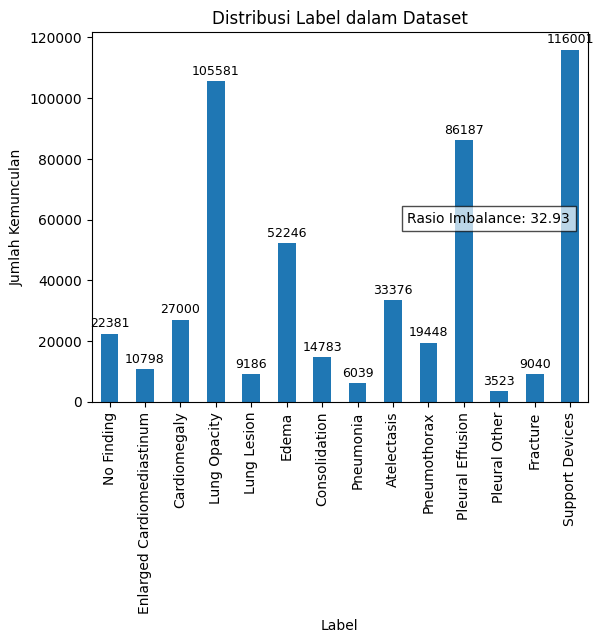

In [54]:
# Ambil 14 label terakhir dari kolom train_df dan valid_df, hitung distribusi label (jumlah 1.0)
label_counts = (df_train[label_cols] == 1.0).sum()

max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

# Buat grafik distribusi label
ax = label_counts.plot(kind='bar')
plt.title('Distribusi Label dalam Dataset')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')

# Tambahkan teks jumlah di atas setiap bar
for i, v in enumerate(label_counts):
    ax.text(i, v + max_count * 0.01, str(v), ha='center', va='bottom', fontsize=9, rotation=0)

# Tambahkan teks rasio imbalance di dalam grafik (pada sumbu y tertinggi)
plt.text(
    x=len(label_counts) - 1, 
    y=max_count - max_count * 0.5, 
    s=f'Rasio Imbalance: {imbalance_ratio:.2f}', 
    ha='right', va='bottom', fontsize=10, 
    bbox=dict(facecolor='white', alpha=0.7)
)
plt.savefig('document/distribusi_label_rawdf.png')
plt.show()

### Korelasi

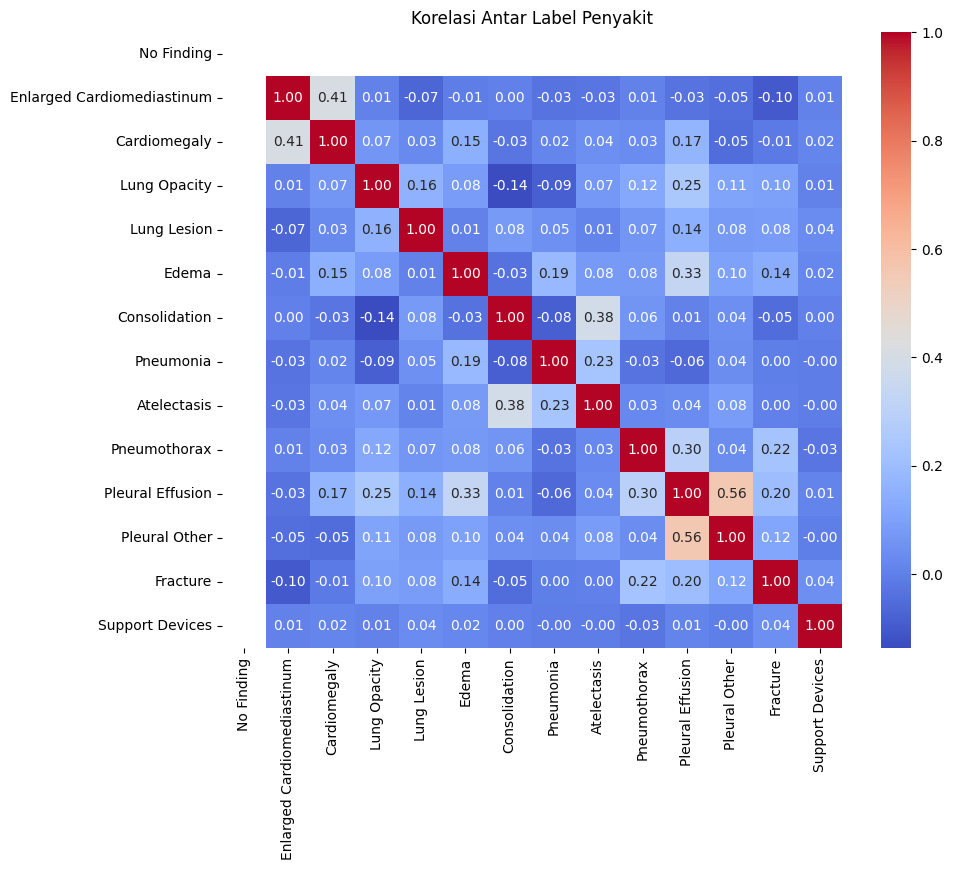

In [55]:
import seaborn as sns

# Menghitung korelasi antar label penyakit pada dataframe df
correlation_matrix = df_train[label_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Label Penyakit")
plt.savefig('document/korelasi_rawdf.png')
plt.show()

## PRE PROSESING

FIlter Range Data `age`

### Selection Fiture

In [56]:
label_cols = [
    'Enlarged Cardiomediastinum', 
    'Cardiomegaly',
    'Lung Opacity', 
    'Lung Lesion', 
    'Edema', 
    'Consolidation',
    'Pneumonia',
    'Atelectasis', 
    'Pneumothorax', 
    'Pleural Effusion',
    # 'Pleural Other',
    'Fracture',
    # 'Support Devices'
]

# Hapus kolom yang tidak diperlukan
columns_to_drop = [
    'Sex', 
    'Age', 
    'Frontal/Lateral', 
    'AP/PA',
    'No Finding',
    # 'Enlarged Cardiomediastinum', 
    # 'Cardiomegaly',
    # 'Lung Opacity', 
    # 'Lung Lesion', 
    # 'Edema', 
    # 'Consolidation',
    # 'Pneumonia',
    # 'Atelectasis', 
    # 'Pneumothorax', 
    # 'Pleural Effusion',
    'Pleural Other',
    # 'Fracture',
    'Support Devices'
    ]

####Drop data Lateral

In [57]:
# # jumlah data sebelum penghapusan
# jumlah_data_sebelum = df.shape[0]
# print(f"Jumlah data sebelum penghapusan: {jumlah_data_sebelum}")

# #drop baris dimana kolom 'Frontal/Lateral' bernilai 'Lateral'
# df = df.drop(df[df['Frontal/Lateral'] == 'Lateral'].index)

# #jumlah data setelah penghapusan
# jumlah_data_setelah = df.shape[0]
# print(f"Jumlah data setelah penghapusan: {jumlah_data_setelah}")

#### Drop Fiture

In [58]:
df_train = df_train.drop(columns=columns_to_drop)
df_val = df_val.drop(columns=columns_to_drop)

print(f"Kolom {columns_to_drop} yang tidak diperlukan telah dihapus.")

Kolom ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding', 'Pleural Other', 'Support Devices'] yang tidak diperlukan telah dihapus.


### U-Once

In [59]:
# Ubah semua nilai -1.0 menjadi 1.0 U-Ones
df_train = df_train.replace(-1.0, 1.0)

### Split Data

In [60]:
# split df_val menjadi valid 70%, dan test 30%

df_val, df_test = train_test_split(df_val, test_size=0.7, random_state=42, shuffle=True)

print(f"train_df shape: {len(df_train)}") 
print(f"valid_df shape: {len(df_val)}") 
print(f"test_df shape: {len(df_test)}") 

train_df shape: 223414
valid_df shape: 70
test_df shape: 164


In [61]:
df_train.tail(3)

,Path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Fracture
223411,CheXpert-v1.0-small/train/patient64538/study1/...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN
223413,CheXpert-v1.0-small/train/patient64540/study1/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


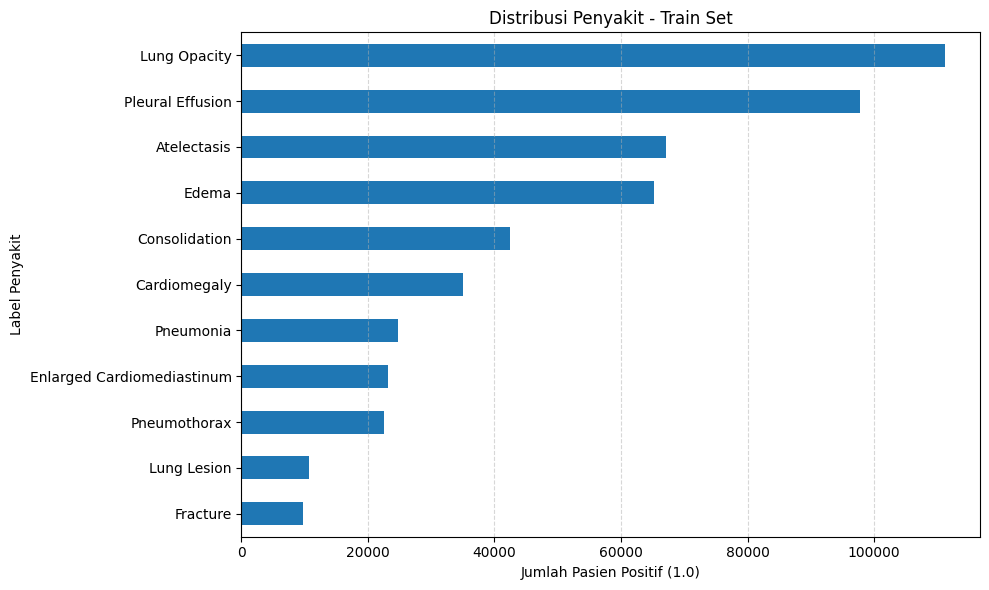

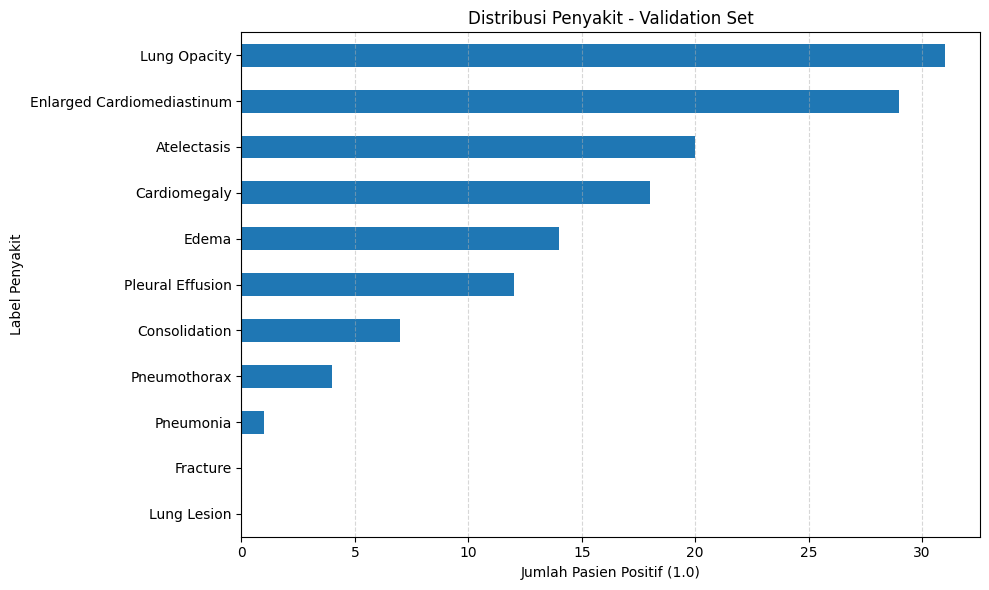

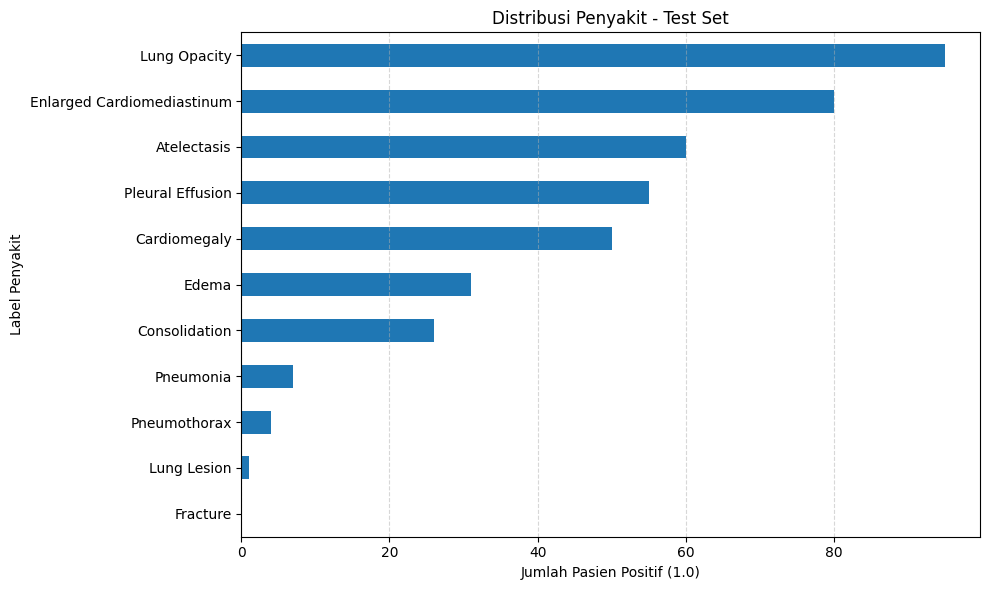

In [62]:
def plot_disease_distribution(df, disease_cols, title):
    # Hitung jumlah nilai 1.0 (positif) di setiap kolom penyakit
    disease_counts = df[disease_cols].sum().sort_values()

    # Plot horizontal bar chart
    plt.figure(figsize=(10, 6))
    disease_counts.plot(kind='barh')
    plt.title(f'Distribusi Penyakit - {title}')
    plt.xlabel('Jumlah Pasien Positif (1.0)')
    plt.ylabel('Label Penyakit')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Gunakan DataFrame sebelum konversi ke format baru (pastikan variabel ini ada)
plot_disease_distribution(df_train, label_cols, 'Train Set')
plot_disease_distribution(df_val, label_cols, 'Validation Set')
plot_disease_distribution(df_test, label_cols, 'Test Set')


In [63]:
# Membuat dataset baru untuk train_df: path -> [label1, label2, ...] hanya untuk label dengan nilai 1.0

def create_label_dataset(df):
    label_columns_temp = df.columns[1:]  # kolom label (kecuali 'Path')
    df2 = []  # list untuk menyimpan data baru
    for idx, row in df.iterrows():
        labels = [col for col in label_columns_temp if row[col] == 1.0]
        df2.append({'Path': row['Path'], 'Labels': labels})

    # Konversi df2 ke DataFrame agar berbentuk tabel
    # df2 = pd.DataFrame(df2, columns=['Path', 'Labels'])
    return df2

df_train = create_label_dataset(df_train)
df_val = create_label_dataset(df_val)

In [64]:
df_train

[{'Path': 'CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg',
  'Labels': []},
 {'Path': 'CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg',
  'Labels': ['Cardiomegaly',
   'Lung Opacity',
   'Edema',
   'Consolidation',
   'Atelectasis',
   'Pleural Effusion',
   'Fracture']},
 {'Path': 'CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg',
  'Labels': ['Lung Opacity', 'Consolidation', 'Fracture']},
 {'Path': 'CheXpert-v1.0-small/train/patient00002/study1/view2_lateral.jpg',
  'Labels': ['Lung Opacity', 'Consolidation', 'Fracture']},
 {'Path': 'CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg',
  'Labels': ['Edema']},
 {'Path': 'CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg',
  'Labels': []},
 {'Path': 'CheXpert-v1.0-small/train/patient00004/study1/view2_lateral.jpg',
  'Labels': []},
 {'Path': 'CheXpert-v1.0-small/train/patient00005/study1/view1_frontal.jpg',
  'Labels': []},
 {'Path': 'CheXpert-v1.0-small/tra

## Hasil Pre-procesing

In [65]:
print("Jumlah data pada train_df:", {len(df_train)})
print("Jumlah data pada valid_df:", {len(df_val)})
print("Jumlah data pada test_df:", {len(df_test)})

Jumlah data pada train_df: {223414}
Jumlah data pada valid_df: {70}
Jumlah data pada test_df: {164}


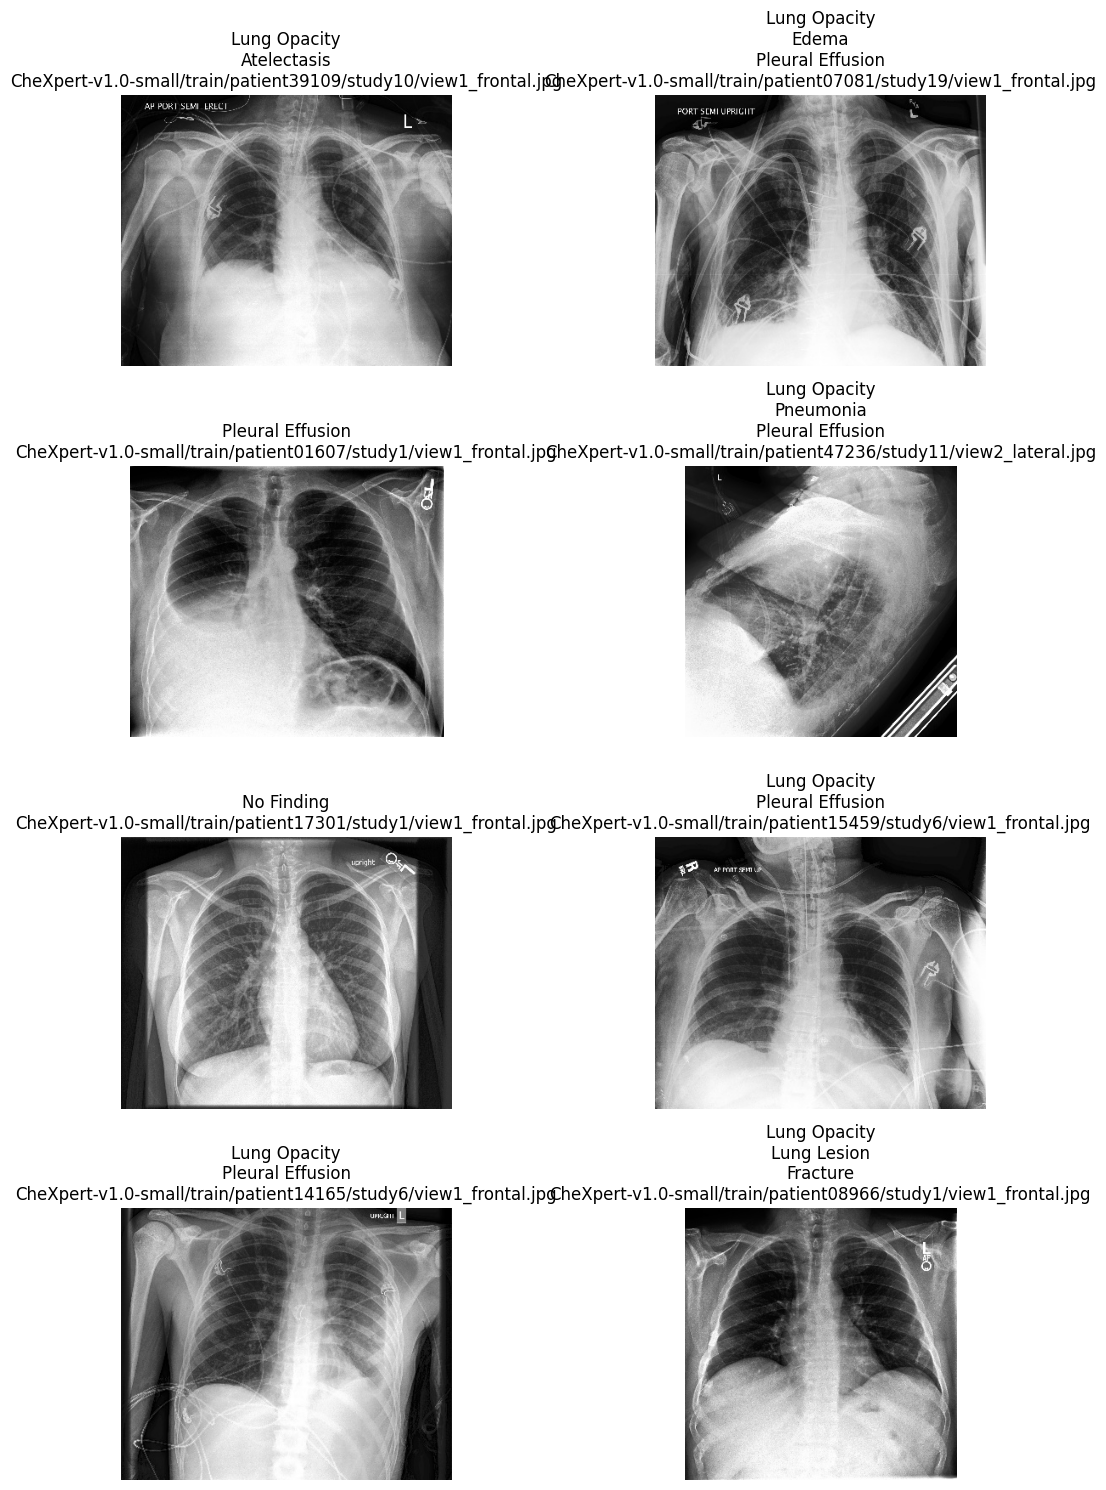

In [66]:
# Pilih 4 sampel acak dari df_train
samples = random.sample(df_train, 8)

plt.figure(figsize=(12, 15))
for i, sample in enumerate(samples):
    img_path = sample['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(4, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    title = ('\n'.join(sample['Labels']) if sample['Labels'] else 'No Finding') + f"\n{sample['Path']}"
    plt.title(title)
plt.tight_layout()
plt.show()

## PROCESING

### Data Augmentation

In [67]:
print(label_cols)

['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Fracture']


In [68]:
# Membuat mapping label ke index dan sebaliknya
label2id = {label: i for i, label in enumerate(label_cols)}
# label2id = {label: i for i, label in enumerate(labels_to_keep)}
id2label = {i: label for label, i in label2id.items()}

# Custom Dataset untuk CheXpert multilabel
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform, label2id):
        # dataframe: list of dict {'Path': ..., 'Labels': [...]}
        self.data = list(dataframe)
        self.transform = transform
        self.label2id = label2id

    def __len__(self):
        # Mengembalikan jumlah data
        return len(self.data)

    def __getitem__(self, idx):
        # Ambil path gambar dan label
        image_path = self.data[idx]['Path']
        findings = self.data[idx]['Labels']
        image = Image.open(image_path).convert("RGB")

        # Membuat vektor biner multilabel
        label_vec = torch.zeros(len(self.label2id))
        for finding in findings:
            if finding in self.label2id:
                label_vec[self.label2id[finding]] = 1.0

        # Transformasi gambar jika ada
        if self.transform:
            image = self.transform(image)

        # Kembalikan dictionary sesuai kebutuhan Trainer HuggingFace
        return {"Path": image, "Labels": label_vec}


### Image Processor dan Tokenizer

In [69]:
print(f"Jumlah label penyakit: {len(label2id)}")

Jumlah label penyakit: 11


In [70]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Hitung loss kustom di sini
        custom_loss = your_custom_loss_function(logits, labels)
        
        return (custom_loss, outputs) if return_outputs else custom_loss

In [71]:
model_name = "google/vit-base-patch16-224-in21k"  # Ganti dengan model yang sesuai
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True,  # This will ignore the classifier head size mismatch
)

def collate_fn(batch):
    pixel_values = torch.stack([item["Path"] for item in batch])
    labels = torch.stack([item["Labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
# Crop tengah dengan hitungan persen (misal: crop 90% area tengah)
class CenterCropPercent:
    def __init__(self, percent):
        self.percent = percent

    def __call__(self, img):
        w, h = img.size
        crop_w, crop_h = int(w * self.percent), int(h * self.percent)
        left = (w - crop_w) // 2
        top = (h - crop_h) // 2
        right = left + crop_w
        bottom = top + crop_h
        return img.crop((left, top, right, bottom))

# Contoh: crop 90% area tengah
train_transform = transforms.Compose([
    CenterCropPercent(0.85),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Tambahkan augmentasi flip horizontal
    transforms.RandomRotation(degrees=15),  # Tambahkan augmentasi rotasi acak
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

val_transform = transforms.Compose([
    CenterCropPercent(0.85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

lung_datasets = {
    "train": CheXpertDataset(df_train, train_transform, label2id),
    "validation": CheXpertDataset(df_train, val_transform, label2id)
}

In [73]:
print(lung_datasets['train'][3])  # Tampilkan contoh data dari dataset train

{'Path': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 'Labels': tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.])}


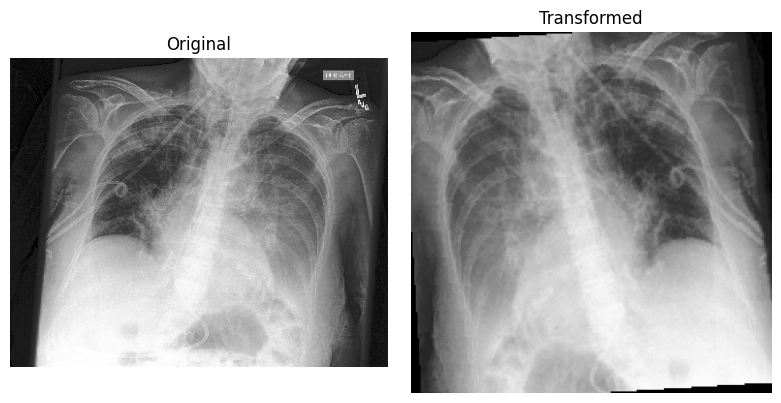

In [74]:
import numpy as np

# Preview hasil transformasi pada satu gambar dari train_df
import matplotlib.pyplot as plt

# sample = train_df[0]
sample = random.choice(df_train)  # Ambil sampel acak dari df_train
img_path = sample['Path']
original_image = Image.open(img_path).convert("RGB")
transformed_image = train_transform(original_image)

# Convert tensor to numpy for visualization
def tensor_to_image(tensor):
    img = tensor.clone().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW to HWC
    img = img * np.array(processor.image_std) + np.array(processor.image_mean)  # unnormalize
    img = np.clip(img, 0, 1)
    return img

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(transformed_image))
plt.title("Transformed")
plt.axis('off')
plt.tight_layout()
plt.savefig('document/transform_preview.png')
plt.show()

### Training

In [75]:
def compute_metrics(pred):
    logits, labels = pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)
    labels = labels.astype(int)

    micro_f1 = f1_score(labels, preds, average="micro")
    macro_f1 = f1_score(labels, preds, average="macro")
    auc = roc_auc_score(labels, probs)
    micro_acc = accuracy_score(labels, preds)
    macro_acc = accuracy_score(labels, preds)  # accuracy_score tidak punya average, jadi sama
    micro_precision = precision_score(labels, preds, average="micro", zero_division=0)
    macro_precision = precision_score(labels, preds, average="macro", zero_division=0)
    micro_recall = recall_score(labels, preds, average="micro", zero_division=0)
    macro_recall = recall_score(labels, preds, average="macro", zero_division=0)

    return {
        "micro_accuracy": micro_acc,
        "macro_accuracy": macro_acc,
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "micro_precision": micro_precision,
        "macro_precision": macro_precision,
        "micro_recall": micro_recall,
        "macro_recall": macro_recall,
        "auc": auc
    }

In [76]:
import torch.nn.functional as F
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(inputs.get("pixel_values"))
        logits = outputs.logits

        # Label Smoothing (multi-label)
        smooth_eps = 0.1
        num_classes = labels.shape[1]
        labels_smooth = labels * (1 - smooth_eps) + (smooth_eps / num_classes)

        loss = F.binary_cross_entropy_with_logits(logits, labels_smooth)

        return (loss, outputs) if return_outputs else loss

In [77]:
!nvidia-smi

Thu Aug  7 03:27:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:05:00.0 Off |                  N/A |
|  0%   39C    P8              9W /  165W |   12545MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Nama metrik yang digunakan untuk memilih model terbaik
metric_name = "auc"

# Inisialisasi TrainingArguments untuk konfigurasi pelatihan
args = TrainingArguments(
    output_dir="chexpert-vit-model",
    eval_strategy="steps",
    save_strategy="steps",
    # eval_strategy="epoch",
    # save_strategy="epoch",
    logging_steps=200,
    save_steps=200,
    eval_steps=200,
    learning_rate=3e-5,                    # Diperbesar dari 1e-5 untuk mempercepat konvergensi
    lr_scheduler_type="cosine",            # Alternatif: "linear", "cosine_with_restarts"
    warmup_steps=500,                      # Warmup penting untuk stabilkan training
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,                   # Dikurangi (early stopping akan handle sisanya)
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',                        # Direktori untuk menyimpan log
    remove_unused_columns=False,
    # greater_is_better=True,                # True jika metrik lebih tinggi lebih baik
    # gradient_checkpointing=True,           # Opsional: hemat memori (trade-off: lebih lambat)
    # max_grad_norm=1.0                     # Kontrol gradient exploding
)

# Inisialisasi Trainer dari HuggingFace
trainer = Trainer(
    model=model,                            # Model yang akan dilatih
    args=args,                              # Argument konfigurasi training
    train_dataset=lung_datasets['train'],   # Dataset training
    eval_dataset=lung_datasets['validation'],# Dataset validasi
    data_collator=collate_fn,               # Fungsi untuk menggabungkan batch data
    compute_metrics=compute_metrics,        # Fungsi untuk menghitung metrik evaluasi
    tokenizer=processor,                     # Image processor/tokenizer
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=10,
        )
    ]
)

# Mulai proses training
trainer.train()
# Simpan model dan processor setelah training
trainer.save_model("chexpert-vit-model")
processor.save_pretrained("chexpert-vit-model")


/tmp/ipykernel_1985/3487089529.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Micro Accuracy,Macro Accuracy,Micro F1,Macro F1,Micro Precision,Macro Precision,Micro Recall,Macro Recall,Auc
200,0.569000,0.486628,0.083956,0.083956,0.362375,0.102091,0.560234,0.242796,0.267796,0.115268,0.592798
400,0.463000,0.451478,0.135815,0.135815,0.483148,0.174157,0.575539,0.209574,0.416317,0.202229,0.606023
600,0.435100,0.425456,0.154113,0.154113,0.355931,0.139774,0.695210,0.191695,0.239197,0.114219,0.647603
800,0.414900,0.411348,0.167796,0.167796,0.446130,0.166337,0.665874,0.273856,0.335434,0.160697,0.661427
1000,0.411100,0.410238,0.148590,0.148590,0.501129,0.182618,0.604760,0.296939,0.427819,0.206845,0.671065
1200,0.401500,0.400198,0.167630,0.167630,0.485958,0.180049,0.649260,0.316717,0.388294,0.187567,0.691524


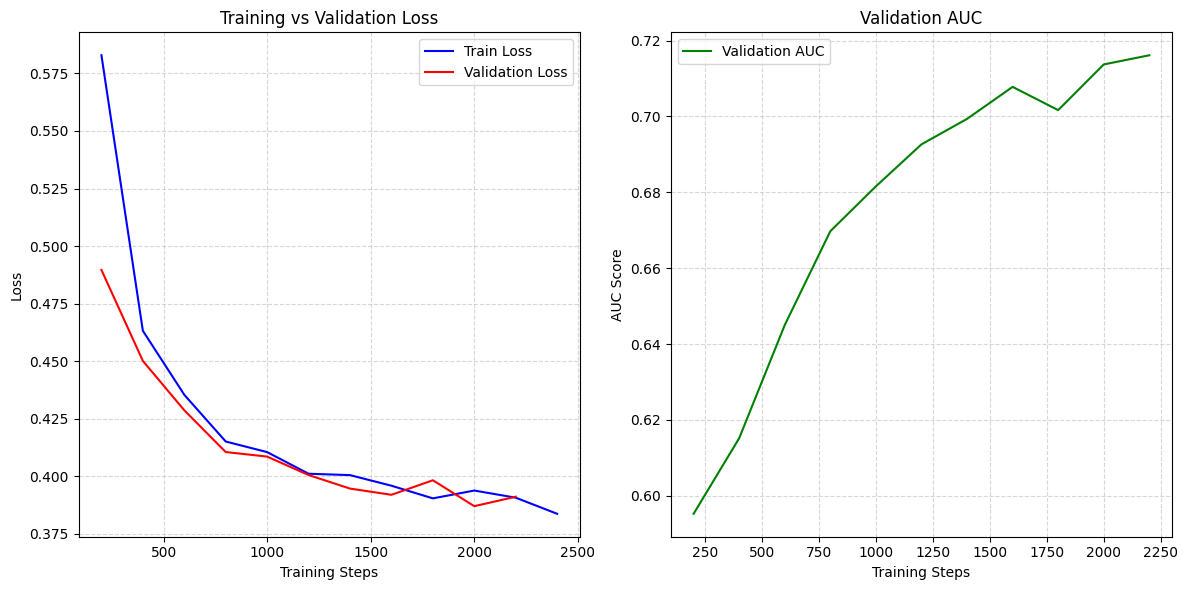

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(trainer, save_path='document/training_evaluation_plot.png'):
    # Ambil log history
    training_logs = trainer.state.log_history
    
    # Inisialisasi penyimpanan data
    train_metrics = {'steps': [], 'loss': []}
    eval_metrics = {'steps': [], 'loss': [], 'auc': []}
    
    # Ekstrak metrik dari log
    for log in training_logs:
        if 'loss' in log and 'step' in log:  # Data training
            train_metrics['steps'].append(log['step'])
            train_metrics['loss'].append(log['loss'])
        elif 'eval_loss' in log:  # Data evaluasi
            eval_metrics['steps'].append(log['step'])
            eval_metrics['loss'].append(log['eval_loss'])
            if 'eval_auc' in log:  # Pastikan nama metrik AUC sesuai
                eval_metrics['auc'].append(log['eval_auc'])
    
    # Buat ics['steps'], train_metrics['loss'], 'b-', label='Train Loss')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_metrics['steps'], train_metrics['loss'], 'b-', label='Train Loss')
    plt.plot(eval_metrics['steps'], eval_metrics['loss'], 'r-', label='Validation Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Plot 2: AUC
    plt.subplot(1, 2, 2)
    if eval_metrics['auc']:  # Hanya plot jika AUC tersedia
        plt.plot(eval_metrics['steps'], eval_metrics['auc'], 'g-', label='Validation AUC')
        plt.xlabel('Training Steps')
        plt.ylabel('AUC Score')
        plt.title('Validation AUC')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
    else:
        print("Warning: AUC data not found in logs!")
    
    # Simpan dan tampilkan
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Cara pakai:
plot_training_metrics(trainer)

In [ ]:
import torch

best_model_dir = 'chexpert-vit-model'  # Ensure this variable is defined

pth_path = best_model_dir + "/model_best.pth"
torch.save(model.state_dict(), pth_path)
print(f"Model state_dict telah diekspor ke: {pth_path}")


Model state_dict telah diekspor ke: chexpert-vit-model/model_best.pth
